In [ ]:
%pip install numpy scipy scikit-learn matplotlib networkx

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import eigh

In [3]:
def load_graph(file_path, weighted=False):
    if weighted:
        graph = nx.read_edgelist(file_path, delimiter=",", data=[('weight', float)])
    else:
        graph = nx.read_edgelist(file_path, delimiter=",")
    return graph

In [4]:
file_path = "example1.dat"
graph = load_graph(file_path)
graph

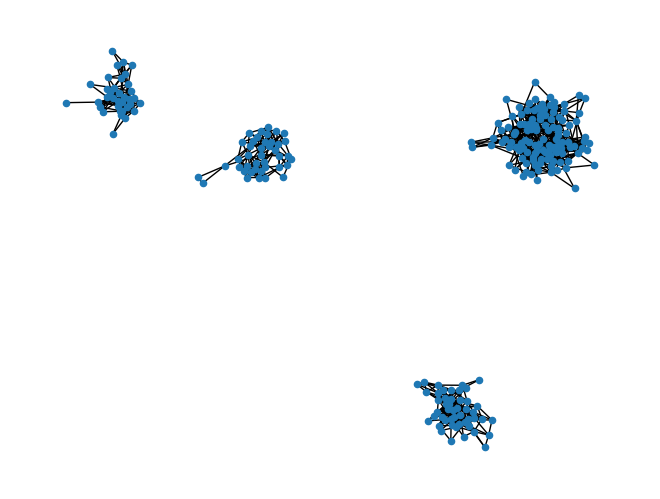

In [5]:
nx.draw(graph, node_size=20)

In [6]:
def build_affinity_matrix(graph, num_nodes, sigma=10):
    edges = nx.edges(graph)
    A = np.zeros((num_nodes, num_nodes))
    shortest_distance_dict = dict(nx.shortest_path_length(graph))
    for i, j in edges:
        if i != j:
            dist = int(shortest_distance_dict.get(i).get(j))
            i = int(i)
            j = int(j)
            A[i - 1, j - 1] = np.exp(-dist ** 2 / (2 * sigma ** 2))
            A[j - 1, i - 1] = A[i - 1, j - 1]  # Symmetric matrix
    return A

In [7]:
num_nodes = np.unique(np.asarray(graph)).shape[0]
num_nodes


241

In [8]:
A = build_affinity_matrix(graph, num_nodes)
A

array([[0.        , 0.99501248, 0.99501248, ..., 0.        , 0.        ,
        0.        ],
       [0.99501248, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.99501248, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [9]:
def construct_diagonal(A):
    return np.diag(np.sum(A, axis=1))

In [10]:
D = construct_diagonal(A)
D

array([[6.96508735, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 7.96009983, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 8.95511231, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.99002496, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 4.9750624 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.99002496]])

In [11]:
def construct_L(A, D):
    D_inv_sqrt = np.diag(1 / np.sqrt(np.diag(D)))
    L = D_inv_sqrt @ A @ D_inv_sqrt
    return L

In [12]:
L = construct_L(A, D)
L

array([[0.        , 0.13363062, 0.12598816, ..., 0.        , 0.        ,
        0.        ],
       [0.13363062, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.12598816, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [13]:
def get_eigen(L):
    eigvals, eigvecs = eigh(L)
    return eigvals, eigvecs

In [14]:
k = 4
eigvals, eigvecs = get_eigen(L)
X = eigvecs[:, num_nodes - k:]
X

array([[ 0.        ,  0.        , -0.0867576 ,  0.        ],
       [ 0.        ,  0.        , -0.09274778,  0.        ],
       [ 0.        ,  0.        , -0.09837388,  0.        ],
       [ 0.        ,  0.        , -0.11359237,  0.        ],
       [ 0.        ,  0.        , -0.11823068,  0.        ],
       [ 0.        ,  0.        , -0.08032193,  0.        ],
       [ 0.        ,  0.        , -0.04637389,  0.        ],
       [ 0.        ,  0.        , -0.07332356,  0.        ],
       [ 0.        ,  0.        , -0.12269378,  0.        ],
       [ 0.        ,  0.        , -0.12700013,  0.        ],
       [ 0.        ,  0.        , -0.13116517,  0.        ],
       [ 0.        ,  0.        , -0.13116517,  0.        ],
       [ 0.        ,  0.        , -0.12700013,  0.        ],
       [ 0.        ,  0.        , -0.10369517,  0.        ],
       [ 0.        ,  0.        , -0.16720344,  0.        ],
       [ 0.        ,  0.        , -0.12269378,  0.        ],
       [ 0.        ,  0.

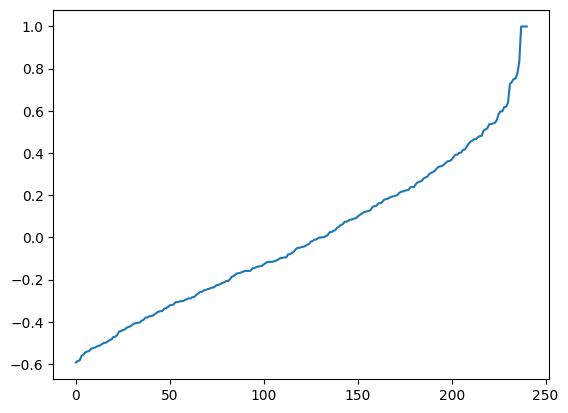

In [15]:
plt.plot(eigvals)
plt.show()

In [16]:
def renormalize_rows(X):
    return X / np.linalg.norm(X, axis=1, keepdims=True)

In [17]:
Y = renormalize_rows(X)
Y

array([[ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  

In [18]:
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(Y)

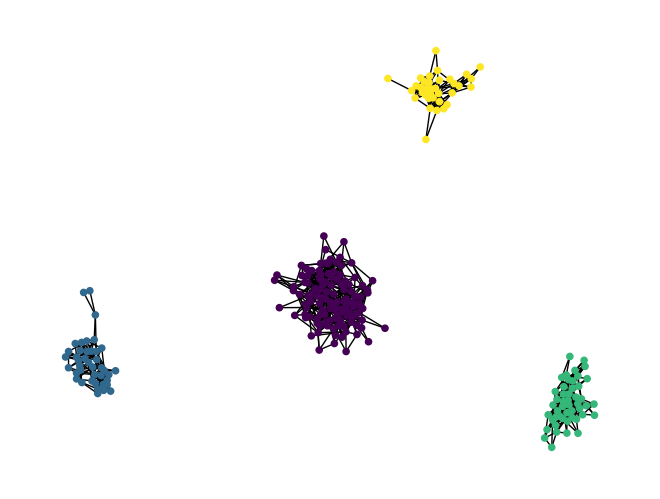

In [19]:
nx.draw(graph, node_size=20, node_color=clusters)

In [20]:
A3 = np.zeros([num_nodes, num_nodes])
for i, j in nx.edges(graph):
    i = int(i)
    j = int(j)
    A3[i-1, j-1] = 1  
    A3[j-1, i-1] = 1  

In [21]:
D3 = np.diag(np.sum(A3, axis=1))

In [22]:
L3 = D3 - A3
L3

array([[ 7., -1., -1., ...,  0.,  0.,  0.],
       [-1.,  8.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  9., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  2.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  5.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  2.]])

In [23]:
eigvals3, eigvecs3 = eigh(L3)

In [24]:
FV = sorted(eigvecs3[:, 1])

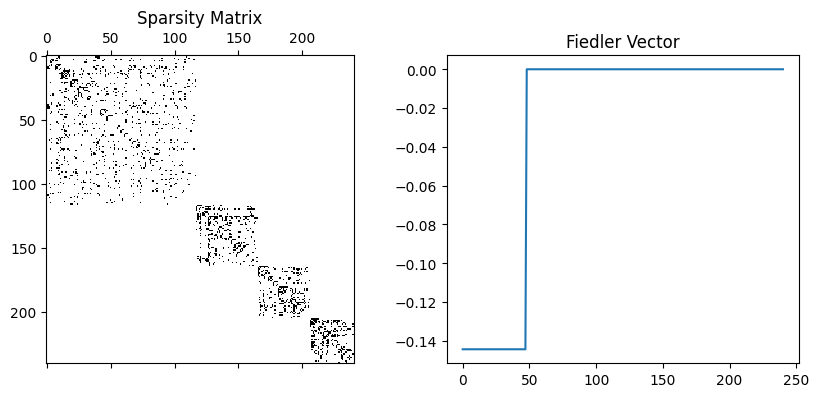

In [25]:
fig=plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.spy(A) 
plt.title('Sparsity Matrix')
plt.subplot(1,2,2)
plt.plot(np.sort(FV))
plt.title('Fiedler Vector')
plt.show()

In [26]:
file_path2 = "example2.dat"
graph2 = load_graph(file_path2, weighted=True)
graph2

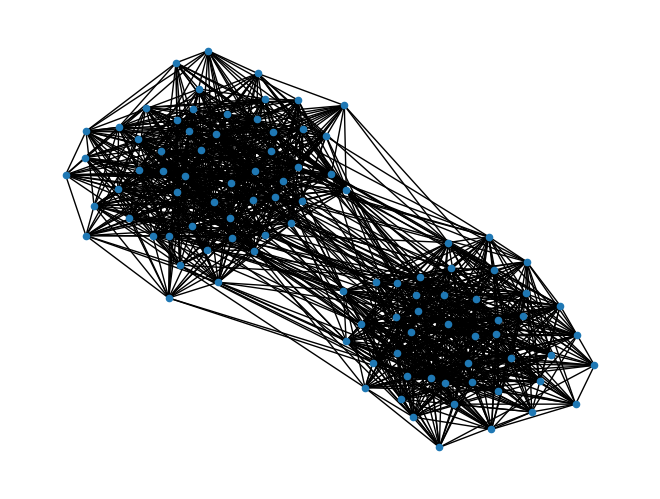

In [27]:
nx.draw(graph2, node_size=20)

In [28]:
num_nodes2 = np.unique(np.asarray(graph2)).shape[0]
num_nodes2

100

In [30]:
A2 = build_affinity_matrix(graph2, num_nodes2, sigma=3.5)
A2

array([[0.        , 0.96000544, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.96000544, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.96000544, 0.96000544,
        0.96000544],
       ...,
       [0.        , 0.        , 0.96000544, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.96000544, ..., 0.        , 0.        ,
        0.96000544],
       [0.        , 0.        , 0.96000544, ..., 0.        , 0.96000544,
        0.        ]])

In [31]:
D2 = construct_diagonal(A2)
D2

array([[22.08012515,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 16.3200925 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 24.96014147, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 16.3200925 ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        22.08012515,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 31.68017956]])

In [32]:
L2 = construct_L(A2, D2)
L2

array([[0.        , 0.05057217, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05057217, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.04756515, 0.04089304,
        0.03413944],
       ...,
       [0.        , 0.        , 0.04756515, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.04089304, ..., 0.        , 0.        ,
        0.0362977 ],
       [0.        , 0.        , 0.03413944, ..., 0.        , 0.0362977 ,
        0.        ]])

In [33]:
k2 = 2
eigvals2, eigvecs2 = get_eigen(L2)
X2 = eigvecs2[:, num_nodes2 - k2:]
X2

array([[-0.10712526, -0.09752945],
       [-0.09427614, -0.0838487 ],
       [ 0.09794083, -0.10369517],
       [-0.09051152, -0.09319262],
       [-0.09229372, -0.0862796 ],
       [ 0.0893462 , -0.10567049],
       [ 0.07568514, -0.11138648],
       [-0.10582617, -0.09319262],
       [-0.09610471, -0.0862796 ],
       [-0.09579519, -0.0862796 ],
       [ 0.10340938, -0.10168148],
       [-0.11425292, -0.10760956],
       [-0.12403347, -0.1132277 ],
       [ 0.08634694, -0.10168148],
       [-0.11126078, -0.10369517],
       [ 0.09139718, -0.1095143 ],
       [ 0.08991972, -0.10168148],
       [-0.08896643, -0.09094668],
       [-0.09165891, -0.09752945],
       [-0.10005799, -0.0996271 ],
       [-0.10527111, -0.09752945],
       [ 0.0899824 , -0.10760956],
       [-0.1119738 , -0.11138648],
       [-0.1066261 , -0.09752945],
       [-0.10090661, -0.09094668],
       [-0.10779066, -0.10369517],
       [-0.07884624, -0.09752945],
       [ 0.09807122, -0.09094668],
       [-0.08257384,

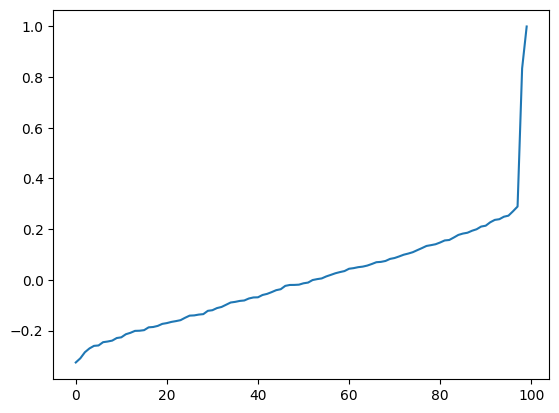

In [34]:
plt.plot(eigvals2)
plt.show()

In [35]:
Y2 = renormalize_rows(X2)
Y2

array([[-0.73944909, -0.67321248],
       [-0.74722164, -0.66457492],
       [ 0.68664762, -0.72699041],
       [-0.6967126 , -0.71735037],
       [-0.73050708, -0.68290512],
       [ 0.6456588 , -0.76362603],
       [ 0.56201719, -0.82712555],
       [-0.75048282, -0.66088996],
       [-0.74411995, -0.66804603],
       [-0.74304756, -0.66923862],
       [ 0.7130389 , -0.70112448],
       [-0.72795381, -0.68562618],
       [-0.73854553, -0.6742036 ],
       [ 0.64729008, -0.76224376],
       [-0.73154122, -0.68179721],
       [ 0.64074384, -0.76775473],
       [ 0.66245286, -0.7491036 ],
       [-0.6992815 , -0.71484641],
       [-0.68483555, -0.72869765],
       [-0.70863097, -0.70557929],
       [-0.7335654 , -0.67961887],
       [ 0.64147833, -0.76714115],
       [-0.70896365, -0.70524503],
       [-0.73788155, -0.67493023],
       [-0.74281545, -0.66949624],
       [-0.720665  , -0.69328346],
       [-0.6286867 , -0.77765869],
       [ 0.73323867, -0.67997137],
       [-0.63813551,

In [36]:
kmeans2 = KMeans(n_clusters=k2, random_state=42)
clusters2 = kmeans2.fit_predict(Y2)

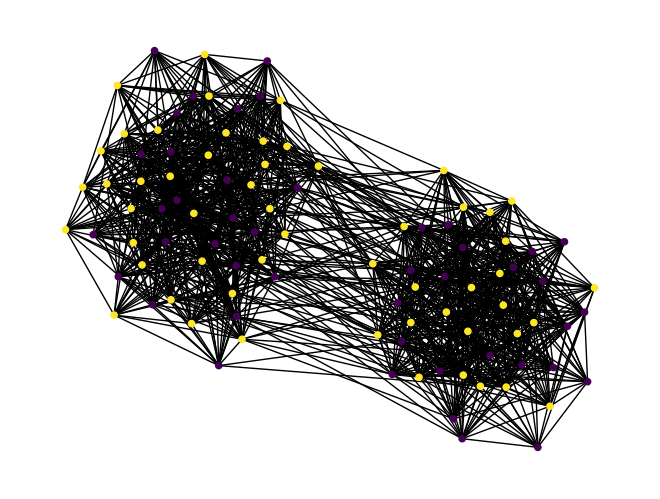

In [37]:
nx.draw(graph2, node_size=20, node_color=clusters2)

In [38]:
A4 = np.zeros([num_nodes2, num_nodes2])
for i, j in nx.edges(graph2):
    i = int(i)
    j = int(j)
    A4[i-1, j-1] = 1  
    A4[j-1, i-1] = 1  

In [39]:
D4 = np.diag(np.sum(A4, axis=1))

In [40]:
L4 = D4 - A4
L4

array([[23., -1.,  0., ...,  0.,  0.,  0.],
       [-1., 17.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 26., ..., -1., -1., -1.],
       ...,
       [ 0.,  0., -1., ..., 17.,  0.,  0.],
       [ 0.,  0., -1., ...,  0., 23., -1.],
       [ 0.,  0., -1., ...,  0., -1., 33.]])

In [41]:
eigvals4, eigvecs4 = eigh(L4)

In [42]:
FV2 = eigvecs4[:, 1]

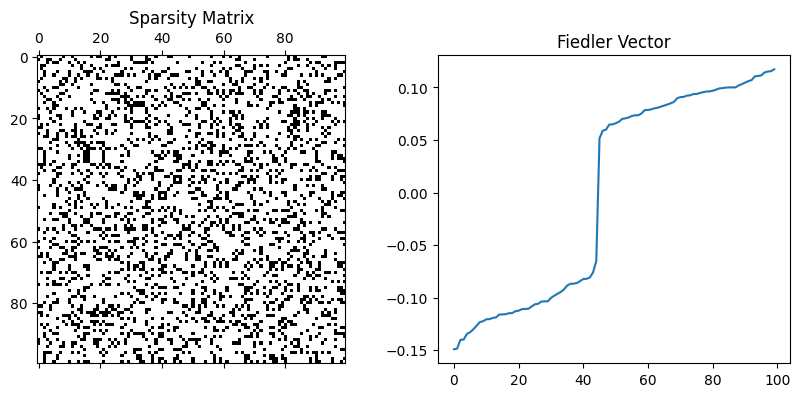

In [43]:
fig=plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.spy(A2) 
plt.title('Sparsity Matrix')
plt.subplot(1,2,2)
plt.plot(np.sort(FV2))
plt.title('Fiedler Vector')
plt.show()